In [1]:
import graphix.command
from graphix.random_objects import Circuit, rand_circuit
from graphix.states import BasicStates
from graphix.sim.density_matrix import DensityMatrixBackend
from graphix.sim.statevec import StatevectorBackend, Statevec
from graphix.pauli import Pauli
from graphix.noise_models import DepolarisingNoiseModel
from graphix.fundamentals import IXYZ
from graphix.command import CommandKind
import stim
from veriphix.client import Client, Secrets, CircuitUtils
import veriphix.client
import numpy as np
import random

/Users/sabdulsa/Codes/veriphix/.venv/lib/python3.12/site-packages/cotengra/hyperoptimizers/hyper.py:33: UserWarning: Couldn't import `kahypar` - skipping from default hyper optimizer and using basic `labels` method instead.
  warnings.warn(


Stim to Pattern

Pattern Simulation (standalone)

In [5]:
n = 6
n_correct_outcome = 0
n_iterations = 10
# Circuit initialization
rd_circ_graphix = Circuit(n)
rd_tableau = stim.Tableau.random(n)

pattern = CircuitUtils.tableau_to_pattern(rd_tableau)

print(f"The pattern has {pattern}")

input_string = rd_tableau.inverse()(stim.PauliString("X"*n))
sign_error = input_string.sign.real == -1
input_state = [
    Pauli(IXYZ(pauli)).eigenstate() for pauli in input_string
]

print(f"Pattern on {pattern.n_node} nodes")
# pattern.standardize()
pattern.minimize_space()

# byproduct_db = veriphix.client.get_byproduct_db(pattern=pattern)
# print(byproduct_db)
# # pattern.get_byproduct_db()
# # pattern.standardize()


# print(pattern.output_nodes)
# ## Measure output nodes, to have classical output
classical_output = pattern.output_nodes
for onode in classical_output:
    pattern.add(graphix.command.M(node=onode))

# pattern.print_pattern(lim=150)
# print(classical_output)

backend = DensityMatrixBackend()

for _ in range(n_iterations) :
    pattern.simulate_pattern(backend=backend, input_state=input_state)

    if sum([pattern.results[i] for i in classical_output])%2 ^ sign_error == 0 :
        n_correct_outcome += 1
print(f"{n_correct_outcome}/{n_iterations}")


The pattern has graphix.pattern.Pattern object with 620 commands and 6 output qubits
Pattern on 147 nodes
10/10


Client simulation (noiseless)

In [9]:
n = 5
n_correct_outcome = 0
n_iterations = 100
# Circuit initialization
rd_circ_graphix = Circuit(n)
rd_tableau = stim.Tableau.random(n)

pattern = CircuitUtils.tableau_to_pattern(rd_tableau)

print(f"The pattern has {pattern}")

input_string = rd_tableau.inverse()(stim.PauliString("X"*n))
sign_error = input_string.sign.real == -1
input_state = [
    Pauli(IXYZ(pauli)).eigenstate() for pauli in input_string
]

print(f"Pattern on {pattern.n_node} nodes")
pattern.minimize_space()

classical_output = pattern.output_nodes
for onode in classical_output:
    pattern.add(graphix.command.M(node=onode))

# pattern.print_pattern(lim=150)
# print(classical_output)

secrets = Secrets(r=True, a=True, theta=True)
client = Client(pattern=pattern, input_state=input_state, secrets=secrets)

backend = DensityMatrixBackend()

for _ in range(n_iterations) :
    client.delegate_pattern(backend=backend)

    if sum([client.results[i] for i in classical_output])%2 ^ sign_error == 0 :
        n_correct_outcome += 1
print(f"{n_correct_outcome}/{n_iterations}")


The pattern has graphix.pattern.Pattern object with 414 commands and 5 output qubits
Pattern on 100 nodes
100/100


Client noisy trap delegation.

Just checking the trap delegation, no need of input state.

In [5]:
n = 3
n_correct_outcome = 0
n_failures = 0
n_iterations = 100
# Circuit initialization
rd_circ_graphix = Circuit(n)
rd_tableau = stim.Tableau.random(n)

pattern = CircuitUtils.tableau_to_pattern(rd_tableau)

print(f"The pattern has {pattern}")



print(f"Pattern on {pattern.n_node} nodes")
pattern.minimize_space()

classical_output = pattern.output_nodes
for onode in classical_output:
    pattern.add(graphix.command.M(node=onode))

# pattern.print_pattern(lim=150)
# print(classical_output)

secrets = Secrets(r=True, a=True, theta=True)
client = Client(pattern=pattern, secrets=secrets)
test_runs = client.create_test_runs()
# Insert noise here !!
noise = DepolarisingNoiseModel(entanglement_error_prob=0.01)

backend = DensityMatrixBackend()

for _ in range(n_iterations) :
    run = random.choice(test_runs)
    trap_outcomes = client.delegate_test_run(run=run, backend=backend, noise_model = noise)
    if sum(trap_outcomes) != 0:
        n_failures += 1
        
print(f"{n_failures}/{n_iterations}")


The pattern has graphix.pattern.Pattern object with 198 commands and 3 output qubits
Pattern on 48 nodes
21/100


Same Clifford circuit, but made non-Clifford due to random $\pi/4$ angles being added.

Just checking the trap delegation, no need of input state.

In [6]:
n_failures = 0

print(f"The pattern has {pattern}")
print(f"Pattern on {pattern.n_node} nodes")
pattern.minimize_space()


for cmd in pattern:
    if cmd.kind == graphix.command.CommandKind.M:
        new_angle = random.choice([0, 1/4, 1/2, 3/4, 1, 5/4, 3/2, 7/4])
        cmd.angle = new_angle

classical_output = pattern.output_nodes
for onode in classical_output:
    pattern.add(graphix.command.M(node=onode))

# pattern.print_pattern(lim=150)
# print(classical_output)

secrets = Secrets(r=True, a=True, theta=True)
client = Client(pattern=pattern, secrets=secrets)
test_runs = client.create_test_runs()
# Insert noise here !!
noise = DepolarisingNoiseModel(entanglement_error_prob=0.01)

backend = DensityMatrixBackend()

for _ in range(n_iterations) :
    run = random.choice(test_runs)
    trap_outcomes = client.delegate_test_run(run=run, backend=backend, noise_model = noise)
    if sum(trap_outcomes) != 0:
        n_failures += 1
    # No computation run here
    # if sum([client.results[i] for i in classical_output])%2 ^ sign_error == 0 :
    #     n_correct_outcome += 1
print(f"{n_failures}/{n_iterations}")


The pattern has graphix.pattern.Pattern object with 153 commands and 0 output qubits
Pattern on 48 nodes
23/100


q0: -X-@-X---@-@---X---------------------
     | | |   | |   |
q1: -|-|-|-H-X-|-H-@-S-H-@---------------
     | | |     |         |
q2: -@-X-@-H---X-------H-X-S-H-S-H-S-S-H-
q0: -X-@-X---@-@---X---------------------
     | | |   | |   |
q1: -|-|-|-H-X-|-H-@-S-H-@---------------
     | | |     |         |
q2: -@-X-@-H---X-------H-X-S-H-S-H-S-S-H-


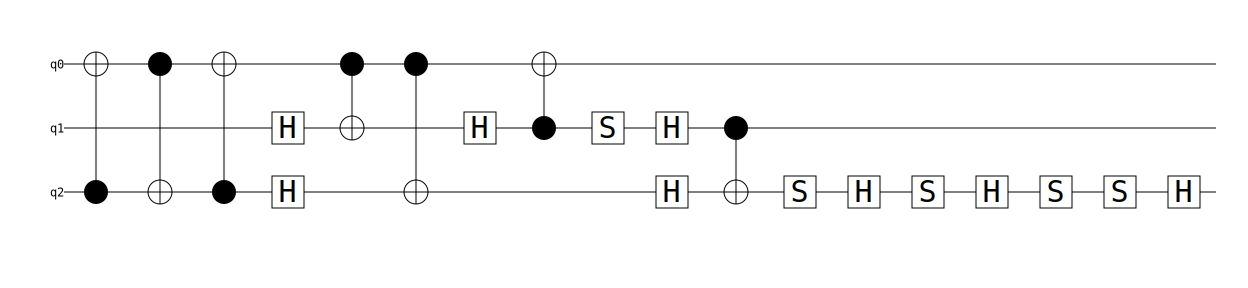

In [24]:
n = 3
rd_circ_graphix = Circuit(n)
rd_tableau = stim.Tableau.random(n)
# pattern = CircuitUtils.tableau_to_pattern(rd_tableau)


other_circuit = stim.Circuit()
rd_circ = rd_tableau.to_circuit()
# print(rd_circ)
for i in rd_circ:
    if i.name == "H":
        for t in i.target_groups():
            qubit = t[0].value
            # print(f"Hadamard on {qubit}")
            rd_circ_graphix.h(qubit)
            other_circuit.append("H", qubit)
            # print(qubit)
    if i.name == "S":
        # print("S on ")
        for t in i.target_groups():
            qubit = t[0].value
            rd_circ_graphix.s(qubit)
            other_circuit.append("S", qubit)
            # print(f"S on {qubit}")
            # print(qubit)
    if i.name == "CX":
        for t in i.target_groups():
            ctrl, targ = t[0].value, t[1].value

            rd_circ_graphix.cnot(control=ctrl, target=targ)
            other_circuit.append("CX", [ctrl, targ])
            # print(f"CX_(c,t) on {ctrl, targ} ")
            # print(ctrl, targ)
print(rd_circ.diagram())
print(other_circuit.diagram())
other_circuit.diagram(type="timeline-svg")



Generating the corresponding +1-eigenstate

In [12]:
# input_stabilizer = rd_tableau.inverse_x_output(0)

inverse_rd_tableau = rd_tableau.inverse()
reverse_string = inverse_rd_tableau(stim.PauliString("X"*n))
stim.Circuit
state = []
for pauli in reverse_string:
    operator = Pauli(IXYZ(pauli))
    state.append(operator.eigenstate())
print(reverse_string)
print(state)

+Y__
[graphix.states.PlanarState(Plane.XY, 1.5707963267948966), graphix.states.PlanarState(Plane.XY, 0.0), graphix.states.PlanarState(Plane.XY, 0.0)]


Running the pattern on the +1-eigenstate as input, and print("yyy") if it works

In [122]:
pattern = rd_circ_graphix.transpile().pattern
print(f"Pattern on {pattern.n_node} nodes")
pattern.minimize_space()


print(pattern.output_nodes)
## Measure output nodes, to have classical output
classical_output = pattern.output_nodes
for onode in classical_output:
    pattern.add(graphix.command.M(node=onode))

print(classical_output)

pattern.simulate_pattern(backend="densitymatrix", input_state=state)
if sum([pattern.results[i] for i in classical_output])%2 == 0 :
    print("yyy")

Pattern on 198 nodes
[181, 185, 189, 193, 128, 197, 177]
[181, 185, 189, 193, 128, 197, 177]


In [7]:

nqubits = 2
depth = 100
circuit = rand_circuit(nqubits, depth)
pattern = circuit.transpile().pattern 
pattern.minimize_space()

print(f"Number of nodes in the pattern : {pattern.n_node}")

## Measure output nodes, to have classical output
classical_output = pattern.output_nodes
for onode in classical_output:
    pattern.add(graphix.command.M(node=onode))



secrets = Secrets(r=True, a=True, theta=True)
client = Client(pattern=pattern, secrets=secrets)

n_good_output = 0

for _i in range(1):
    backend = DensityMatrixBackend()
    client.delegate_pattern(backend=backend)

Number of nodes in the pattern : 865
Number of occurrences of output '00' : 1
